In [303]:
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import numpy as np
repo_path = '/Users/ehsan/Desktop/NFL_prediction/'
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [157]:
def find_position_number(row, pos):
    try:
        return [int(i.strip().split(' ')[0]) for i in row.split(',') if pos in i][0]
    except:
        return 0

dataset = pd.read_csv(repo_path+'datasets/train.csv')
dataset.loc[dataset.PossessionTeam == 'ARZ', 'PossessionTeam'] = 'ARI'
dataset.loc[dataset.PossessionTeam == 'BLT', 'PossessionTeam'] = 'BAL'
dataset.loc[dataset.PossessionTeam == 'CLV', 'PossessionTeam'] = 'CLE'
dataset.loc[dataset.PossessionTeam == 'HST', 'PossessionTeam'] = 'HOU'
dataset.loc[dataset.PossessionTeam == 'ARZ', 'FieldPosition'] = 'ARI'
dataset.loc[dataset.PossessionTeam == 'BLT', 'FieldPosition'] = 'BAL'
dataset.loc[dataset.PossessionTeam == 'CLV', 'FieldPosition'] = 'CLE'
dataset.loc[dataset.PossessionTeam == 'HST', 'FieldPosition'] = 'HOU'
dataset[['X', 'Y', 'S', 'A', 'Orientation']] = dataset[['X', 'Y', 'S', 'A', 'Orientation']].fillna(0)
fraction = [1, 1/60, 0]
dataset['TimeRemained'] = dataset.GameClock.apply(lambda x: sum([a*b for a, b in zip(fraction, map(int, x.split(':')))]))
dataset['DefendersInTheBox'] = dataset['DefendersInTheBox'].fillna(value = 7) # most common value
dataset['DistanceToGoal'] = np.where(dataset['PossessionTeam'] == dataset['FieldPosition'], 50 + dataset['YardLine'], dataset['YardLine'])
def_pos = ['DL', 'LB', 'DB', 'OL']
off_pos = ['RB', 'TE', 'WR', 'QB']
for dp in def_pos:
    dataset['D-'+dp] = [find_position_number(row, dp) for row in dataset.DefensePersonnel]
for op in off_pos:
    dataset['O-'+op] = [find_position_number(row, op) for row in dataset.OffensePersonnel]
dataset['O-QB'] = np.where(dataset['O-QB'] == 0, 1, dataset['O-QB'])
dataset['O-OL'] = 11- dataset[['O-RB', 'O-TE', 'O-WR', 'O-QB']].sum(axis = 1)


/Users/ehsan/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [235]:
def numerize(x):
    try:
        return str(round(float(x)))
    except ValueError:
        return None
# WindSpeed and WindDirection are switched for some rows in the dataset, the following script is used to switch them back to the sampe spot
mask = dataset['WindDirection'].map(lambda x: str(x).isnumeric()) & (dataset['WindSpeed'].map(lambda x: not str(x).isnumeric()))
wrong_ds = dataset[mask]
dataset.loc[mask, 'WindDirection'] = wrong_ds['WindSpeed']
dataset.loc[mask, 'WindSpeed'] = wrong_ds['WindDirection'].astype(int)
dataset['WindSpeed'] = dataset['WindSpeed'].astype(str).str.replace('(mph|MPH|MPh|-.*|g.*)', '')
dataset['WindSpeed'] = dataset['WindSpeed'].astype(str).str.strip()
dataset['WindSpeed'] = dataset['WindSpeed'].apply(lambda x: numerize(x))

### Imputing Windspeed and Temperature using simple machine learning algorithm

In [342]:
null_ws = dataset.WindSpeed.isnull().sum()
if null_ws:
    print('prepare for imputation')

prepare for imputation


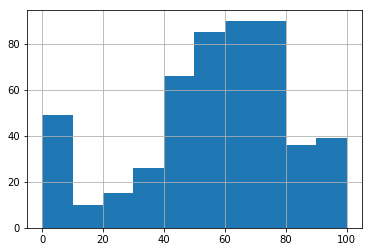

In [370]:
imputation.Humidity.hist()
plt.show()

In [402]:
def prepare_for_imputation(dataset, training = True, ws_rf = None, hu_rf = None, temp_rf = None):
    imputation = dataset[['HomeTeamAbbr', 'GameId', 'WindSpeed', 'Humidity', 'Temperature']].drop_duplicates()
    imputation['GameId'] = pd.to_datetime(imputation['GameId'].astype(str).str[:-2])
    TeamAbbr_enc = {'ARI': 1, 'ATL': 2, 'BAL': 3, 'BUF': 4, 'CAR': 5, 'CHI': 6, 'CIN': 7, 'CLE': 8, 
                    'DAL': 9, 'DEN': 10, 'DET': 11, 'GB': 12, 'HOU': 13, 'IND': 14, 'JAX': 15, 
                    'KC': 16, 'LA': 17, 'LAC': 18, 'MIA': 19, 'MIN': 20, 'NE': 21, 'NO': 22, 
                    'NYG': 23, 'NYJ': 24, 'OAK': 25, 'PHI': 26, 'PIT': 27, 'SEA': 28, 'SF': 29, 
                    'TB': 30, 'TEN': 31, 'WAS': 32}
    imputation['HomeTeamAbbr'] = imputation['HomeTeamAbbr'].replace(TeamAbbr_enc).fillna(0)
    imputation['GameId'] = ((imputation['GameId'] - pd.to_datetime('2017-05-01')).dt.days)/(3*365)
    ## imputing windspeed
    ws_imputation = imputation.copy()
    ws_imputation['Temperature'].fillna(64, inplace = True)
    ws_imputation['Humidity'].fillna(70, inplace = True)
    if training:
        ws_train = ws_imputation[ws_imputation.WindSpeed.notnull()]
        ws_train['WindSpeed'] = ws_train['WindSpeed'].astype(int)
        training_set = ws_train[ws_train.notnull().all(axis = 1)]
        x_train, x_test, y_train, y_test = train_test_split(training_set.drop(['WindSpeed'], axis = 1), 
                                                    training_set.WindSpeed,
                                                   test_size = 0.2)
        ws_rf = RandomForestRegressor(max_features=0.2, max_leaf_nodes=100,
                                  min_samples_leaf = 5,
                                  min_samples_split = 2,
                                  n_estimators = 500)
        ws_rf.fit(x_train, y_train)
    mask = ws_imputation.WindSpeed.isnull()
    ws_imputation.loc[mask, 'WindSpeed'] = ws_rf.predict(ws_imputation.loc[mask, ['HomeTeamAbbr', 'GameId', 'Humidity', 'Temperature']])
    imputation['WindSpeed'] = ws_imputation['WindSpeed']
    ## imputing Humidity
    hu_imputation = imputation.copy()
    hu_imputation['Temperature'].fillna(64, inplace = True)
    if training:
        hu_train = hu_imputation[hu_imputation.Humidity.notnull()]
        hu_train['Humidity'] = hu_train['Humidity'].astype(int)
        training_set = hu_train[hu_train.notnull().all(axis = 1)]
        x_train, x_test, y_train, y_test = train_test_split(training_set.drop(['Humidity'], axis = 1), 
                                                    training_set.Humidity,
                                                   test_size = 0.2)
        hu_rf = RandomForestRegressor(max_features=0.2, max_leaf_nodes=100,
                                  min_samples_leaf = 5,
                                  min_samples_split = 2,
                                  n_estimators = 500)
        hu_rf.fit(x_train, y_train)
    mask = hu_imputation.Humidity.isnull()
    hu_imputation.loc[mask, 'Humidity'] = hu_rf.predict(hu_imputation.loc[mask, ['HomeTeamAbbr', 'GameId', 'WindSpeed', 'Temperature']])
    imputation['Humidity'] = hu_imputation['Humidity']
    ## imputing Temperature
    temp_imputation = imputation.copy()
    if training:
        temp_train = temp_imputation[temp_imputation.Temperature.notnull()]
        temp_train['Temperature'] = temp_train['Temperature'].astype(int)
        training_set = temp_train[temp_train.notnull().all(axis = 1)]
        x_train, x_test, y_train, y_test = train_test_split(training_set.drop(['Temperature'], axis = 1), 
                                                    training_set.Temperature,
                                                   test_size = 0.2)
        temp_rf = RandomForestRegressor(max_features=0.2, max_leaf_nodes=100,
                                  min_samples_leaf = 5,
                                  min_samples_split = 2,
                                  n_estimators = 500)
        temp_rf.fit(x_train, y_train)
    mask = temp_imputation.Temperature.isnull()
    temp_imputation.loc[mask, 'Temperature'] = temp_rf.predict(temp_imputation.loc[mask, ['HomeTeamAbbr', 'GameId', 'WindSpeed', 'Humidity']])
    imputation['Temperature'] = temp_imputation['Temperature']

    return(imputation, ws_rf, hu_rf, temp_rf)
imputed_dataset, ws_model, hu_model, temp_model = prepare_for_imputation(dataset)


/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [331]:
training_set = ws_train[ws_train.notnull().all(axis = 1)]
TeamAbbr_enc = {'ARI': 1, 'ATL': 2, 'BAL': 3, 'BUF': 4, 'CAR': 5, 'CHI': 6, 'CIN': 7, 'CLE': 8, 
                'DAL': 9, 'DEN': 10, 'DET': 11, 'GB': 12, 'HOU': 13, 'IND': 14, 'JAX': 15, 
                'KC': 16, 'LA': 17, 'LAC': 18, 'MIA': 19, 'MIN': 20, 'NE': 21, 'NO': 22, 
                'NYG': 23, 'NYJ': 24, 'OAK': 25, 'PHI': 26, 'PIT': 27, 'SEA': 28, 'SF': 29, 
                'TB': 30, 'TEN': 31, 'WAS': 32}
training_set['HomeTeamAbbr'] = training_set['HomeTeamAbbr'].replace(TeamAbbr_enc).fillna(0)

/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,HomeTeamAbbr,GameId,WindSpeed,Humidity,Temperature
0,21,2017-09-07,8,77.0,63.0
1144,4,2017-09-10,6,53.0,65.0
2112,6,2017-09-10,10,57.0,64.0
2948,7,2017-09-10,9,43.0,68.0
4334,8,2017-09-10,11,53.0,63.0


In [333]:
# def impute_windspeed(dataset)
training_set = ws_train[ws_train.notnull().all(axis = 1)]
TeamAbbr_enc = {'ARI': 1, 'ATL': 2, 'BAL': 3, 'BUF': 4, 'CAR': 5, 'CHI': 6, 'CIN': 7, 'CLE': 8, 
                'DAL': 9, 'DEN': 10, 'DET': 11, 'GB': 12, 'HOU': 13, 'IND': 14, 'JAX': 15, 
                'KC': 16, 'LA': 17, 'LAC': 18, 'MIA': 19, 'MIN': 20, 'NE': 21, 'NO': 22, 
                'NYG': 23, 'NYJ': 24, 'OAK': 25, 'PHI': 26, 'PIT': 27, 'SEA': 28, 'SF': 29, 
                'TB': 30, 'TEN': 31, 'WAS': 32}
training_set['HomeTeamAbbr'] = training_set['HomeTeamAbbr'].replace(TeamAbbr_enc).fillna(0)
training_set['GameId'] = ((ws_train['GameId'] - pd.to_datetime('2017-05-01')).dt.days)/(3*365)
x_train, x_test, y_train, y_test = train_test_split(training_set.drop(['WindSpeed'], axis = 1), 
                                                    training_set.WindSpeed,
                                                   test_size = 0.2)
rf = RandomForestRegressor(max_features=0.2, max_leaf_nodes=100,
                          min_samples_leaf = 5,
                          min_samples_split = 2,
                          n_estimators = 500)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


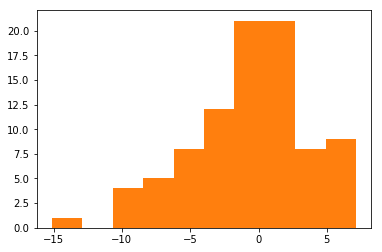

In [339]:
MSE = np.sqrt(np.mean((y_pred - y_test)**2))
plt.hist(y_pred - y_test)
plt.show()

In [254]:
# temperature and windspeed is being reported once for each GameId
imputation = dataset[['HomeTeamAbbr', 'GameId', 'WindSpeed', 'Humidity', 'Temperature']].drop_duplicates()
imputation['GameId'] = pd.to_datetime(imputation['GameId'].astype(str).str[:-2])

In [255]:
#reformat the GameId to date
ws_train = imputation[imputation.WindSpeed.notnull()]
# ws_train = imputation
ws_train['WindSpeed'] = ws_train['WindSpeed'].astype(int)
# ws_train.set_index('GameId', inplace = True)
# ws_train['WindSpeed'].astype(float)
# ws_train.to_csv('ws_imputation_dataset.csv', index = False)

/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [247]:
imputation[imputation.WindSpeed.notnull()].shape

(442, 5)

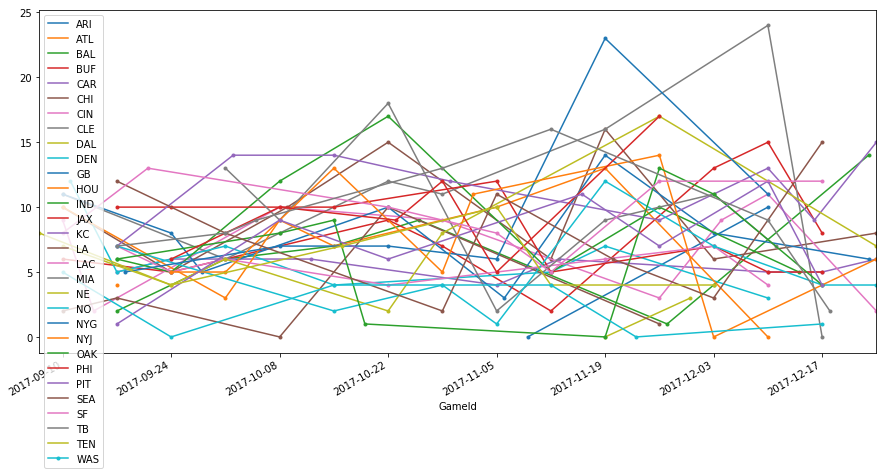

In [231]:
fig, ax = plt.subplots(figsize=(15,7))
ws_train[:200].groupby(['HomeTeamAbbr'])['WindSpeed'].plot(legend = True, style = '.-')
plt.show()

In [217]:
print(ws_train.groupby(['HomeTeamAbbr']).count())

              GameId  WindSpeed
HomeTeamAbbr                   
ARI                7          7
ATL                4          4
BAL               16         16
BUF               16         16
CAR               16         16
CHI               16         16
CIN               16         16
CLE               16         16
DAL                4          4
DEN               16         16
GB                16         16
HOU               16         16
IND               16         16
JAX               16         16
KC                16         16
LA                13         13
LAC               16         16
MIA               16         16
NE                15         15
NO                16         16
NYG               15         15
NYJ               16         16
OAK               16         16
PHI               16         16
PIT               16         16
SEA               16         16
SF                16         16
TB                16         16
TEN               16         16
WAS     

In [66]:
from collections import Counter
cnt = Counter()
dataset[['Stadium', 'StadiumType', 'GameId']].drop_duplicates().groupby(['Stadium', 'StadiumType']).count().reset_index()

,Stadium,StadiumType,GameId
0,AT&T Stadium,Indoor,10
1,AT&T Stadium,Indoors,4
2,AT&T Stadium,Outdoor,1
3,AT&T Stadium,Outdoors,1
4,Arrowhead Stadium,Outdoor,16
...,...,...,...
76,U.S. Bank Stadium,Indoors,10
77,University of Phoenix Stadium,Dome,7
78,University of Phoenix Stadium,Outdoor Retr Roof-Open,1
79,Wembley Stadium,Outdoor,1


/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  if __name__ == '__main__':


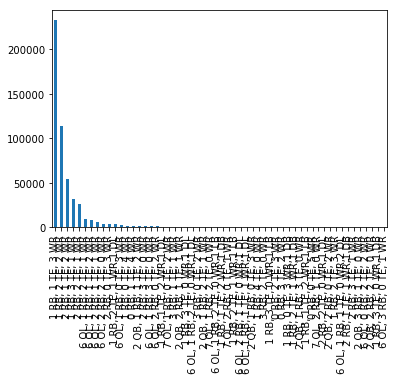

In [38]:
dataset.OffensePersonnel.value_counts().plot('bar')
plt.show()

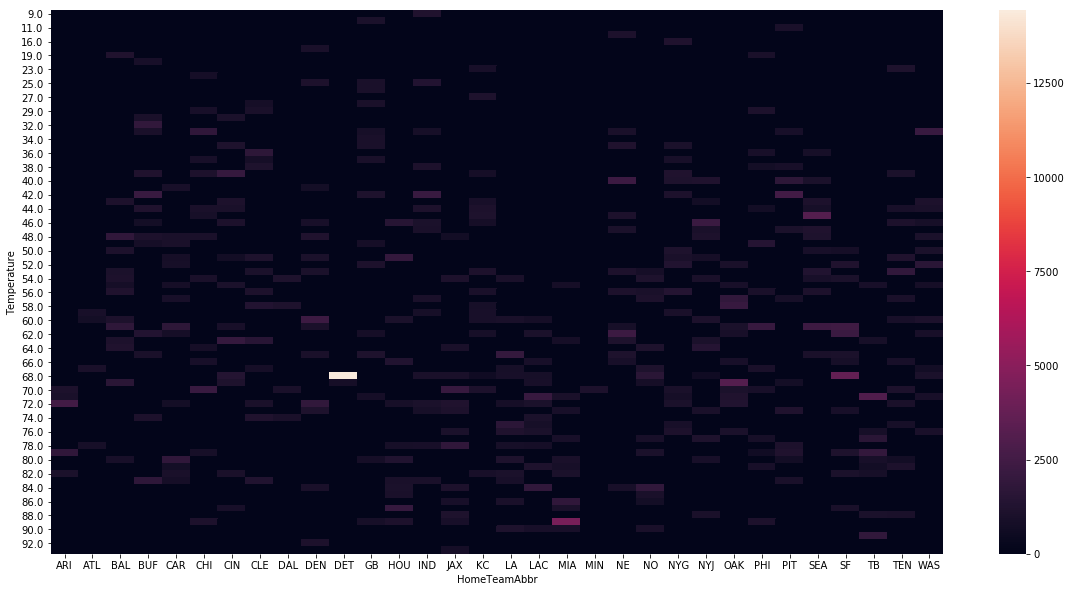

In [79]:
plt.figure(figsize=(20, 10))
col1, col2 = 'Temperature', 'HomeTeamAbbr'
confusion_matrix = pd.crosstab(dataset[col1], dataset[col2])
sns.heatmap(confusion_matrix)
plt.show()
# df=pd.DataFrame({'a':['a','d','c'],'c':['a','b','c'],'d':['a','b','c'],'e':['a','b','c']})

### Finding the number of observation per feature and average yard 
One of the items that might has an impact on the yards could be defense team positional group. Let's see how many different positions a team can stay:

In [4]:
def plot_feature_yard(feature_name):
    defense_counts = pd.DataFrame.from_dict(Counter(dataset[feature_name]), orient='index').reset_index()
    defense_yard = dataset[[feature_name, 'Yards']].groupby(feature_name).mean().reset_index()
    defense_info = pd.merge(defense_counts, defense_yard, how='inner', left_on=['index'], right_on=[feature_name]).drop('index', axis=1).rename(columns={0:'freq'})
    plt.figure(figsize=(15, 4))
    defense_info.plot(x = feature_name, y = 'freq', kind = 'bar', figsize=(15, 4))
    defense_info['Yards'].plot(secondary_y = True, rot = 90)
plot_feature_yard('Stadium')

### Visualizing the missing value pattern

In [ ]:
fig, ax = plt.subplots(figsize=(14.5,5))
sns.heatmap(dataset.isnull(), cbar = False, ax = ax)

### Correlation between variables


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
corr = dataset.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


### Data Cleaning and imputation
We can idnetify the unique part of the game by grouping by GameId and TimeSnap and since the max and minimum of the group by is 22 (equal to the total number of players) it could be a unique identifier

In [5]:
unique_play = dataset.groupby(['GameId', 'TimeSnap']).count()[['PlayId']].reset_index()
assert unique_play.PlayId.min() == unique_play.PlayId.max()

### Displaying a situation

The game is selected is with Id 2017111902 and snap 2017-11-19T20:27:53.000Z
Home team ['GB'] Feild Position ['BLT'] Possession Team ['BLT'] Down [1] Move: ['left'] Yard moved [5]
YardLine 66 yard_to_down 56


/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


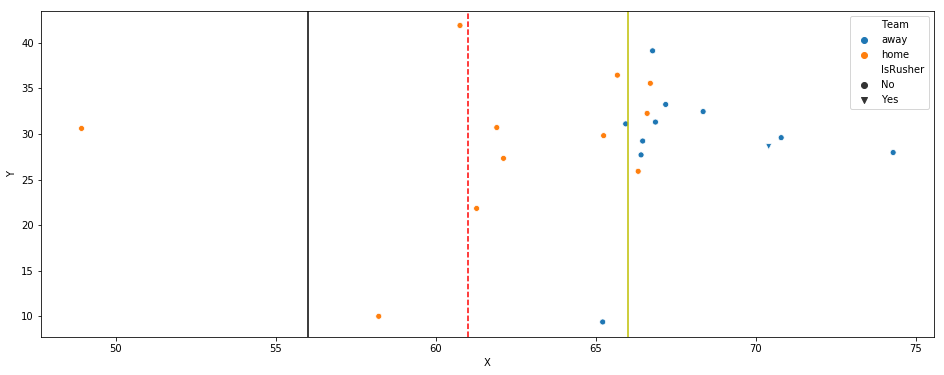

In [24]:
GameId = dataset.GameId.sample().values[0]
TimeSnap = dataset[dataset.GameId == GameId]['TimeSnap'].sample().values[0]
def plot_field(GameId, TimeSnap):
    filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '+', '-')
    plt.figure(figsize=(16, 6))
    print('The game is selected is with Id', GameId, 'and snap', TimeSnap)
    game_data = dataset[(dataset.GameId == GameId) & (dataset.TimeSnap == TimeSnap)]
    game_data['IsRusher'] = np.where(game_data.NflIdRusher == game_data.NflId, 'Yes', 'No')
#     print(game_data.columns)
    sns.scatterplot(x = 'X', 
                   y = 'Y',
                   data = game_data,
                   hue = 'Team',
                   style = 'IsRusher',
                   markers = filled_markers)
    YardLine = game_data.reset_index().YardLine[0] + 10 # The first 10 yard is the touch down area
    if (game_data.PossessionTeam.unique() != game_data.FieldPosition.unique() and game_data.PlayDirection.unique()[0] == 'right') or \
    (game_data.PossessionTeam.unique() == game_data.FieldPosition.unique() and game_data.PlayDirection.unique()[0] == 'left'):
        YardLine = 110 - game_data.reset_index().YardLine[0]
    # CenterPosition = game_data[game_data.Position == 'C']['X'].values[0]
    if game_data.PlayDirection.unique()[0] == 'right':
        Yard10 = YardLine + game_data.Distance.unique()[0]
        DownPosition = YardLine + game_data.Yards.unique()[0]
    else:
        Yard10 = YardLine - game_data.Distance.unique()[0]
        DownPosition = YardLine - game_data.Yards.unique()[0]
    print("Home team", game_data.HomeTeamAbbr.unique(), "Feild Position", game_data.FieldPosition.unique(), "Possession Team", game_data.PossessionTeam.unique(), "Down", game_data.Down.unique(),
         'Move:', game_data.PlayDirection.unique(), "Yard moved", game_data.Yards.unique())
    print('YardLine', YardLine, 'yard_to_down', Yard10)
    plt.axvline(YardLine, 0, 50, color = 'y')
    plt.axvline(Yard10, 0, 50, color = 'k')
    plt.axvline(DownPosition, 0, 50, color = 'r', linestyle = '--')
    plt.show()
    # plt.axvline(CenterPosition, 0, 50, color = 'orange')
plot_field(GameId, TimeSnap)

In [18]:
GameStrategy = dataset.groupby(['GameId', 'TimeSnap']).Position.value_counts().unstack(fill_value = 0)
no_qb = GameStrategy[GameStrategy.QB == 0]
# Games with no quarter back
no_qb

,Position,C,CB,DB,DE,DL,DT,FB,FS,G,HB,...,OLB,OT,QB,RB,S,SAF,SS,T,TE,WR
GameId,TimeSnap,,,,,,,,,,,,,,,,,,,,,
2017092410,2017-09-24T22:22:44.000Z,1,2,0,1,0,2,0,1,2,0,...,1,0,0,2,0,0,1,2,3,1
2017111208,2017-11-12T21:07:48.000Z,1,2,0,1,0,2,0,1,2,0,...,2,1,0,1,0,0,1,1,2,3


The game is selected is with Id 2017092800 and snap 2017-09-29T04:17:03.000Z
Home team ['GB'] Feild Position ['CHI'] Possession Team ['CHI'] Down [4] Move: ['right'] Yard moved [3]
YardLine 59 yard_to_down 60


/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


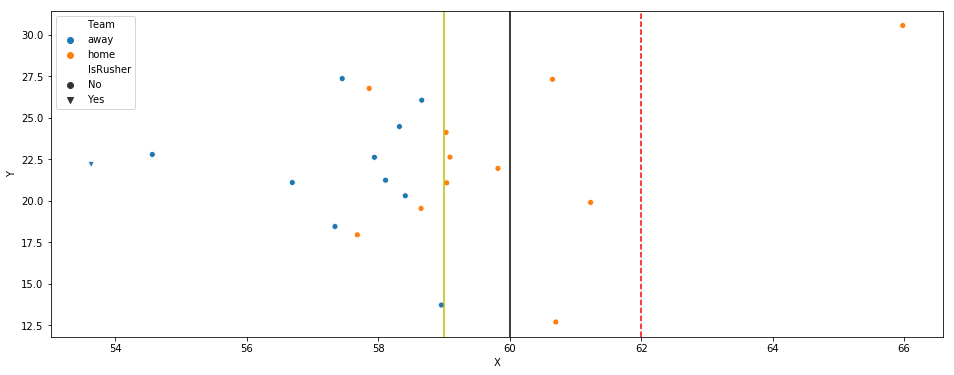

In [23]:
plot_field(GameId = 2017092800, TimeSnap='2017-09-29T04:17:03.000Z')

The game is selected is with Id 2017112600 and snap 2017-11-26T20:04:11.000Z
Home team ['ATL'] Feild Position ['ATL'] Possession Team ['ATL'] Down [1] Move: ['right'] Yard moved [4]
YardLine 59 yard_to_down 69


/Users/ehsan/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


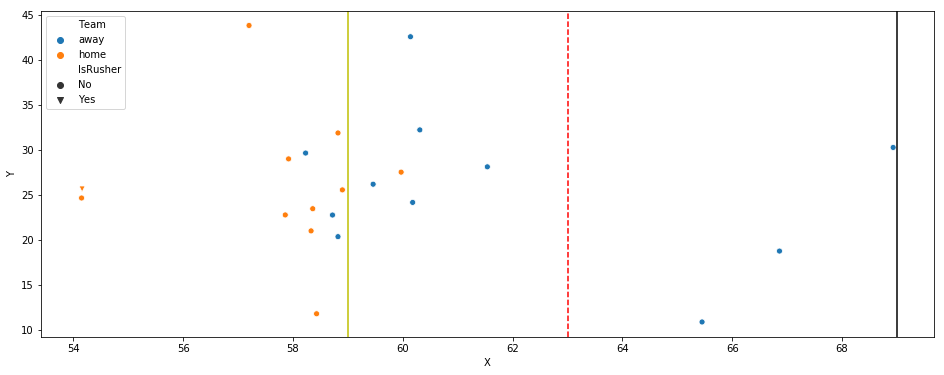

In [28]:
GameId = dataset.GameId.sample().values[0]
TimeSnap = dataset[dataset.GameId == GameId]['TimeSnap'].sample().values[0]

plot_field(GameId, TimeSnap)